In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [66]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [67]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [68]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [69]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [70]:
# Print all of the classes mapped to the Base
for class_name in Base.classes.keys():
    print(class_name)

measurement
station


In [71]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# assign the station class to a variable called `Station`
Station = Base.classes.station

In [72]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

### The most recent data in the dataset is 23 August 2017

In [73]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).one()[0]
print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


### Calculating and plotting the prevous 12 months of precipitation data.

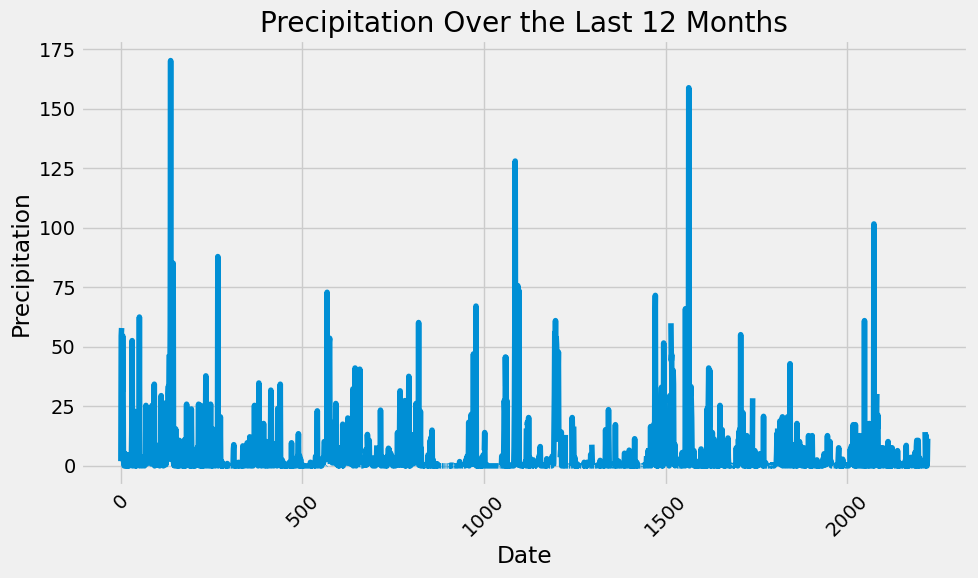

In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

#most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df['prcp'].plot(title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary statistics for the precipitation data

In [76]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['prcp'].describe()
print(summary_statistics)

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: prcp, dtype: float64


# Exploratory Station Analysis

### Total number of stations in the dataset

In [77]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
print("Total number of stations:", total_stations)

Total number of stations: 9


### Station activity - Most active station is USC00519281

In [78]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


### Lowest, highest, and average termperature for station USC00519281

In [83]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).one()

# Unpack the results into respective variables
lowest_temp, highest_temp, average_temp = temperature_stats

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp:.2f}")

Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.04


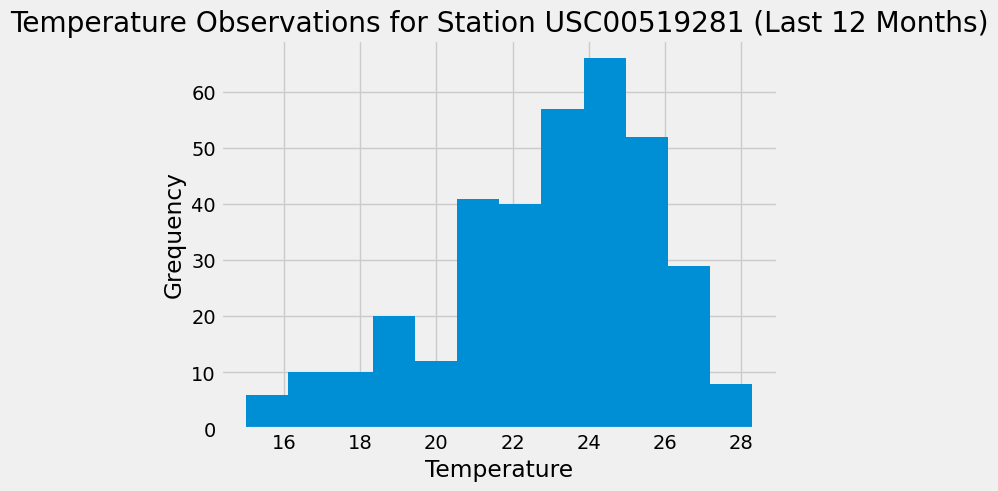

In [84]:
# Using the most active station id
most_active_station_id = 'USC00519281'

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Extract temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12)
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [85]:
# Close Session
session.close()
